In [1]:
import torch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
usps_train = datasets.USPS(root="./data", train=True, transform=ToTensor(), download=True)

In [3]:
device = 'cuda'

In [4]:
class_indices = {i: [] for i in range(10)}
for idx, (_, label) in enumerate(usps_train):
    if len(class_indices[label]) < 500:
        class_indices[label].append(idx)

# Collect indices for the final dataset
final_indices = []
for indices in class_indices.values():
    final_indices.extend(indices)

# Subset the dataset
train_dataset = Subset(usps_train, final_indices)

# DataLoader
minibatches = DataLoader(train_dataset, batch_size=500, shuffle=True)

print(f"Number of samples in training dataset: {len(train_dataset)}")


Number of samples in training dataset: 5000


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(10, 128)
        self.l2 = nn.Linear(128, 16*16)
        self.a = nn.ReLU()
        self.s = nn.Sigmoid()
    def forward(self, X):
        X = self.a(self.l1(X))
        X = self.s(self.l2(X))
        return X
        
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(16*16, 128)
        self.l2 = nn.Linear(128, 1)
        self.a = nn.ReLU()
        self.s = nn.Sigmoid()
    def forward(self, X):
        X = self.a(self.l1(X))
        X = self.s(self.l2(X))
        return X

In [6]:
G = Generator().to(device)
D = Discriminator().to(device)
loss_fn = nn.BCELoss()
lr = 0.15
optimizerG = torch.optim.SGD(G.parameters(), lr=lr)
optimizerD = torch.optim.SGD(D.parameters(), lr=lr)
epochs = 500

CE_D = torch.zeros(epochs)
CE_G = torch.zeros(epochs)

for start in range(epochs):
    for X, Y in minibatches:
        #loss acumalation for real images
        D.zero_grad()
        X_real, Y_real = nn.Flatten()(X), torch.ones((500, 1))
        X_real, Y_real = X_real.to(device), Y_real.to(device)
        outD = D(X_real)
        loss_real = loss_fn(outD, Y_real)
        #loss acumlation for fake images
        z = torch.randn(500, 10).to(device)
        X_fake, Y_fake = G(z), torch.zeros((500, 1))
        X_fake, Y_fake = X_fake.to(device), Y_fake.to(device)
        outD = D(X_fake)
        loss_fake = loss_fn(outD, Y_fake)
        #Gradient descent part for Discriminator
        lossD = loss_real + loss_fake
        lossD.backward()
        optimizerD.step()
        #Training of the Generator
        G.zero_grad()
        z = torch.randn(500, 10).to(device)
        Y = torch.ones((500, 1)).to(device)
        outG = G(z)
        outD = D(outG)
        lossG = loss_fn(outD, Y)
        lossG.backward()
        optimizerG.step()
    CE_D[start] = lossD
    CE_G[start] = lossG

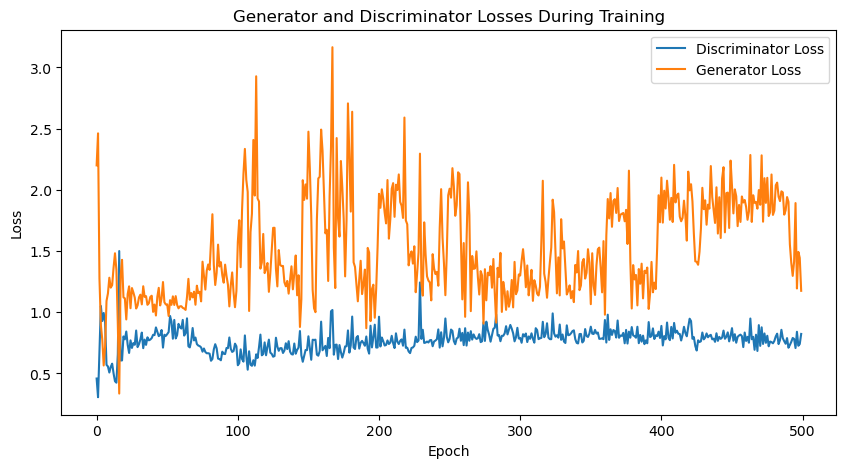

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(CE_D.detach().cpu().numpy(), label="Discriminator Loss")
plt.plot(CE_G.detach().cpu().numpy(), label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Losses During Training")
plt.legend()
plt.show()

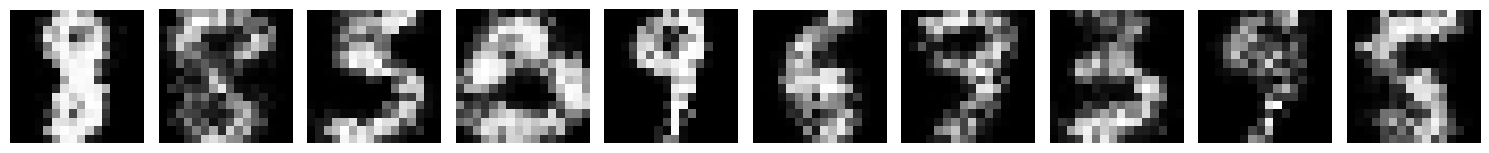

In [9]:
generated = G(torch.randn(10, 10).to(device))  
generated = generated.view(10, 16, 16)  

plt.figure(figsize=(15, 3))  # Adjusted figure size for better visualization
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated[i].cpu().detach().numpy(), cmap="gray")
    plt.axis("off")  # Turn off axis for cleaner display
plt.tight_layout()
plt.show()
